# 分析概要
- スポーツニュースアプリで2023年バスケットボールワールドカップ(バスケW杯)の大会特別ページを作成した。
- 大会特別ページがDAUに与えた影響を知りたい。
- 大会特別ページ期間中は夏の甲子園と重なる部分がある
- 毎年夏の甲子園の開催期間中はDAUが増加するため、大会特別ページ掲載開始日前後では比較できない
  - 掲載期間中のDAUの変化が甲子園か大会特別ページによるものかが判断できないため
- そのため、大会特別ページ掲載開始日前後の差と昨年の同じ期間の差を比較する
  - 差分の差分法を用いてDAUに与える効果を推定する

# 大会特別ページ概要
- 大会特別ページ掲載期間：8月5日 - 9月15日

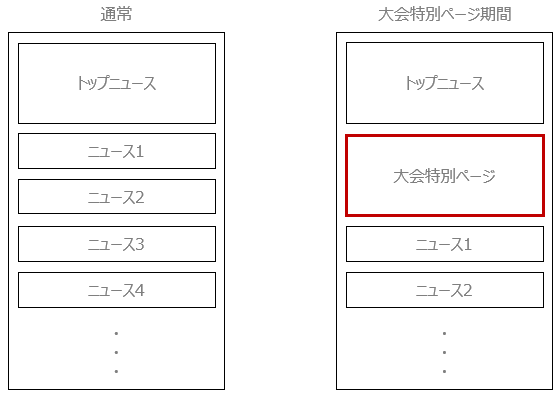


### 分析の詳細
- 掲載期間の2023年の8月5日-9月15日のDAUと掲載期間前の2023年7月1日-8月4日のDAUの差
- 前年である2022年の8月5日-9月15日のDAUと2022年7月1日-8月4日のDAUの差
- 上記二つの差の差を比較する

# 補足
### バスケW杯大会概要
- 2023年8月25日 - 9月10日
- 日本代表の試合日程
  - 8月25日 対ドイツ
  - 8月27日 対フィンランド
  - 8月29日 対オーストラリア
  - 8月31日 対ベネズエラ
  - 9月2日 対カーボベルデ
  
### 甲子園の大会概要
- 2022年
  - 8月6日 - 22日
- 2023年
  - 8月6日 - 23日

### 留意点
2022年と比較して2023年は甲子園の開催期間が1日多いのでDAUが多く評価される可能性がある

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# サンプルデータ作成

### 日付の作成

In [2]:
# 分析対象の日付作成
control_date=pd.period_range(start='2022-07-01', end='2022-09-15', freq='D')
treatment_date=pd.period_range(start='2023-07-01', end='2023-09-15', freq='D')

ndarry_date=np.concatenate([control_date, treatment_date], 0)

# 甲子園対象日付
control_koushien_date=pd.period_range(start='2022-08-06', end='2022-08-22', freq='D')
treatment_koushien_date=pd.period_range(start='2023-08-06', end='2023-08-23', freq='D')

### DAUの作成

In [3]:
pre_date_n=36
target_date_n=41

# 2022年のDAUを作成
control_pre_DAU=np.random.normal(110, 5, size=pre_date_n).astype(int)
control_target_DAU=np.random.normal(110, 5, size=target_date_n).astype(int)

# 2023年のDAUを作成
treatment_pre_DAU=np.random.normal(90, 5, size=pre_date_n).astype(int)
## バスケットボールワールドカップの影響を反映させるため全体に+40
treatment_target_DAU=40+np.random.normal(90, 5, size=target_date_n).astype(int)

ndarray_DAU_base=np.concatenate([control_pre_DAU, control_target_DAU, treatment_pre_DAU, treatment_target_DAU], 0)


# 特別ページ掲載期間中はDAUが1日ごとに1ユーザ増加する
## 2日目はベースから2ユーザ増加、3日目はベースから3ユーザ増加といった感じ
_ndarray_DAU=np.empty(0)
for i in range(len(ndarry_date)):
    if '2023-08-05'<=str(ndarry_date[i])<='2023-09-15':
        _ndarray_DAU=np.append(_ndarray_DAU, ndarray_DAU_base[i]+(i-113))
    else :
        _ndarray_DAU=np.append(_ndarray_DAU, ndarray_DAU_base[i])



# 甲子園の影響を考慮
## 甲子園期間中は「甲子園n日目*2」で増加していく
## 2日目はベースから4ユーザ増加、3日目はベースから6ユーザ増加といった感じ
ndarray_DAU=np.empty(0)
for i in range(len(ndarry_date)):
    if '2022-08-06'<=str(ndarry_date[i])<='2022-08-22':
        ndarray_DAU=np.append(ndarray_DAU, _ndarray_DAU[i]+(i-pre_date_n+1)*2)
    elif '2023-08-06'<=str(ndarry_date[i])<='2023-08-23':
        ndarray_DAU=np.append(ndarray_DAU, _ndarray_DAU[i]+(i-114)*2)
    else :
        ndarray_DAU=np.append(ndarray_DAU, _ndarray_DAU[i])

In [4]:
df_base=pd.DataFrame({'日付':ndarry_date
                    , 'DAU':ndarray_DAU
                     })

# グラフ作成

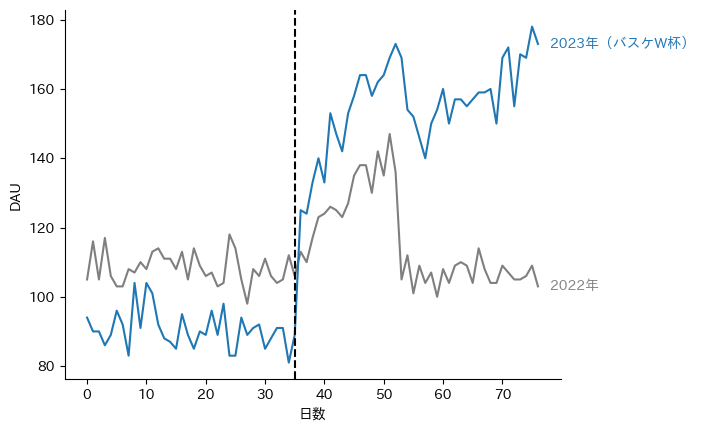

In [5]:
cnt_dau=df_base[df_base['日付']<='2022-09-15']['DAU']
tre_dau=df_base[df_base['日付']>'2022-09-15']['DAU']
plt.plot(range(len(cnt_dau)),cnt_dau, c='tab:gray')
plt.plot(range(len(tre_dau)),tre_dau, c='tab:blue')
plt.axvline(x=35, linestyle='--',color='black')

plt.ylabel('DAU')
plt.xlabel('日数')

lst_y=[cnt_dau[len(cnt_dau)-1], tre_dau[len(cnt_dau)+len(tre_dau)-1]]
lst_label=['2022年', '2023年（バスケW杯）']
lst_col=['gray', 'tab:blue']
for i in range(2):
    plt.text(len(tre_dau)+1, lst_y[i], lst_label[i], ha='left', va='center',color=lst_col[i])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()
plt.close()

# 結果

### 回帰分析用のフラグ付け

In [6]:
# control群（2022年）とtreatment群（2023年）に分ける
## 2022は0を、2023年は1を付与する
lst_treatment_flg=[]
for i in range(len(ndarry_date)):
    if '2022-07-01'<=str(ndarry_date[i])<='2022-09-15':        
        lst_treatment_flg.append(0)
    else :
        lst_treatment_flg.append(1)
df_base['treatment_flg']=lst_treatment_flg

# バスケW杯の開催月日に分ける
## 7月1日から8月4日までを0, 8月5日から9月15日までを1とする
## 2022年と2023年ともに上記の月日でフラグ付けをする
lst_target_flg=[]
for i in range(len(ndarry_date)):
    if '2022-07-01'<=str(ndarry_date[i])<='2022-08-04':        
        lst_target_flg.append(0)
    elif '2023-07-01'<=str(ndarry_date[i])<='2023-08-04':
        lst_target_flg.append(0)
    else :
        lst_target_flg.append(1)
df_base['target_flg']=lst_target_flg

In [7]:
df_base['treatment*target']=df_base['treatment_flg'] * df_base['target_flg']

### 回帰による推定

In [8]:
import pingouin as pg
pg.linear_regression(df_base[['treatment_flg', 'target_flg', 'treatment*target']], df_base["DAU"])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,108.371429,1.931640,56.103322,1.463222e-102,0.810888,0.807105,104.554691,112.188167
1,treatment_flg,-17.771429,2.731752,-6.505507,1.089027e-09,0.810888,0.807105,-23.169111,-12.373746
2,target_flg,7.128571,2.615453,2.725559,7.183327e-03,0.810888,0.807105,1.960684,12.296459
3,treatment*target,56.223810,3.698809,15.200516,3.570107e-32,0.810888,0.807105,48.915313,63.532306


### 単純な平均値の比較

In [9]:
cnt_no_tgt=df_base[(df_base['treatment_flg']==0) &  (df_base['target_flg']==0)]['DAU'].mean()
cnt_tgt=df_base[(df_base['treatment_flg']==0) &  (df_base['target_flg']==1)]['DAU'].mean()
tre_no_tgt=df_base[(df_base['treatment_flg']==1) &  (df_base['target_flg']==0)]['DAU'].mean()
tre_tgt=df_base[(df_base['treatment_flg']==1) &  (df_base['target_flg']==1)]['DAU'].mean()
(tre_tgt - tre_no_tgt) - (cnt_tgt - cnt_no_tgt)

56.223809523809535

回帰分析と同じ結果になった